# **Network Visualiztion**


## **Imports**


In [1]:
import os
import sys
from warnings import filterwarnings
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv

%matplotlib inline
%load_ext autotime

load_dotenv()
filterwarnings("ignore")

module_path = os.path.abspath(os.path.join("../../.."))
parent_dir = os.path.dirname(os.getcwd())
if module_path not in sys.path:
    sys.path.append(module_path)

time: 2.84 ms (started: 2022-04-18 21:16:09 -04:00)


In [2]:
import tweepy
import numpy as np
import pandas as pd
import dask.dataframe as dd
import ast
from scipy.stats import gmean
import networkx as nx
import seaborn as sns
from utils.utils import get_ego_graph, draw_nx_graph, draw_plotly_graph

PATH = os.getcwd()
PROJECT = str(Path(PATH).parents[0])
TWITTER_USERNAME = os.getenv("TWITTER_USERNAME")
TWITTER_API_KEY = os.getenv("TWITTER_API_KEY")
TWITTER_API_SECRET = os.getenv("TWITTER_API_SECRET")
TWITTER_API_BEARER_TOKEN = os.getenv("TWITTER_API_BEARER_TOKEN")
CLOUD_STORAGE_BUCKET = os.getenv("CLOUD_STORAGE_BUCKET")

client = tweepy.Client(TWITTER_API_BEARER_TOKEN, wait_on_rate_limit=True)

time: 9.3 s (started: 2022-04-18 21:16:09 -04:00)


## **Read**


### **Node Centrality (Subset)**


In [3]:
df_cen = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/data/processed/node_centrality.csv").compute()
print(df_cen.shape)
df_cen.head()

(46, 9)


user    cen_ev    cen_dg    cen_pg  rank_cen_ev  rank_cen_dg  \
0  116994659  0.071912  0.000428  0.000009     1.000000     0.978261   
1   44196397  0.060478  0.000620  0.000010     0.913043     1.000000   
2   18208354  0.062272  0.000402  0.000009     0.934783     0.956522   
3  106204123  0.069367  0.000367  0.000009     0.978261     0.913043   
4   95092020  0.054365  0.000314  0.000009     0.826087     0.804348   

   rank_cen_pg  rank_combined                                  username  
0     0.956522       0.978100               ['Sam Harris:SamHarrisOrg']  
1     1.000000       0.970131                    ['Elon Musk:elonmusk']  
2     0.760870       0.879506                    ['Joe Rogan:joerogan']  
3     0.717391       0.862119               ['Jonathan Haidt:JonHaidt']  
4     0.913043       0.846552  ['Dr Jordan B Peterson:jordanbpeterson']

time: 14.3 s (started: 2022-04-18 21:16:19 -04:00)


### **Node Features**


In [4]:
nodes = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/data/processed/node_features*.csv").compute()
print(nodes.shape)
nodes.head()

(102296, 9)


id                name  \
0  794433401591693312    Aran Komatsuzaki   
1          2509504696       Jericho Brown   
2          1938030980         Angel Wicky   
3           335544910  AC Justice Project   
4             2622261        Brian Ulicny   

                                   profile_image_url         username  \
0  https://pbs.twimg.com/profile_images/150798283...  arankomatsuzaki   
1  https://pbs.twimg.com/profile_images/111968593...     jerichobrown   
2  https://pbs.twimg.com/profile_images/144139505...   Angel_Wicky_II   
3  https://pbs.twimg.com/profile_images/145415812...       ACJProject   
4  https://pbs.twimg.com/profile_images/730781652...          bulicny   

   verified  followers_count  following_count  tweet_count  listed_count  
0     False            16111               72         1865           210  
1      True            40468              708       118856           408  
2      True           355162              410        15435          1119  
3     False             1049              497         3425            39  
4     False              796             2459         4624            68

time: 1.82 s (started: 2022-04-18 21:16:44 -04:00)


### **Graph**


In [5]:
df = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/data/users_following*.csv").compute()
df.following = df.following.apply(ast.literal_eval)
df = df.explode('following')

#if you need a full graph including the user
user = client.get_user(
    username=TWITTER_USERNAME,
    user_fields=["id"],
).data.id
df_following = df.copy().dropna()
df_user = pd.DataFrame({"user": user, "following": df_following.user.unique()})
df_with_user = pd.concat([df_user, df_following])

#create  a graph
edges = df_with_user.copy().dropna()
edges.columns = ['source', 'target']
edges['source'] = edges['source'].astype(int)
edges['target'] = edges['target'].astype(int)
edges['weight'] = 1
print(df.shape, edges.shape)

G = nx.from_pandas_edgelist(
    edges,
    create_using=nx.DiGraph(),
    edge_attr=True
)
print(f"Nodes: {len(G.nodes())}, Edges: {len(G.edges())}")
print(f"Average Clustering: {round(nx.average_clustering(G), 3)}")

(157768, 2) (157906, 3)
Nodes: 114509, Edges: 157905
Average Clustering: 0.073
time: 32.7 s (started: 2022-04-18 14:43:40 -04:00)


## **Explore**


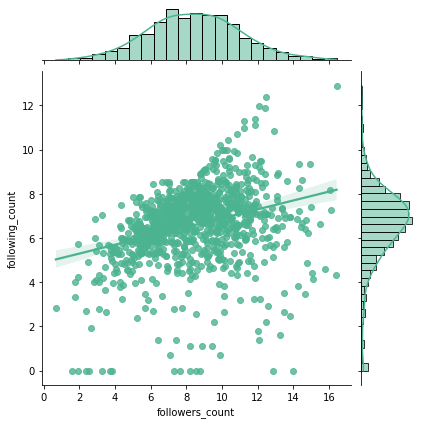

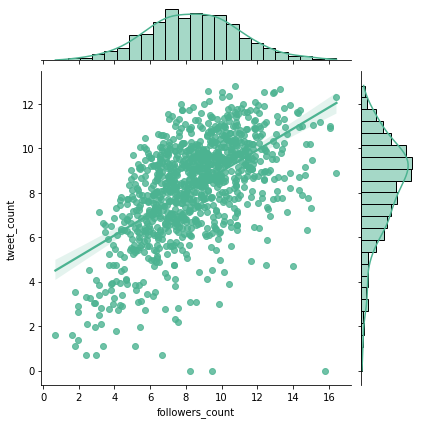

time: 4.59 s (started: 2022-04-18 14:44:13 -04:00)


In [6]:
v_nodes = nodes.sample(1000, random_state = 42)
sns.jointplot(x=np.log(1+v_nodes.followers_count), y=np.log(1+v_nodes.following_count), kind="reg", color="#4CB391");
sns.jointplot(x=np.log(1+v_nodes.followers_count), y=np.log(1+v_nodes.tweet_count), kind="reg", color="#4CB391");

1427408443296657408
Nodes: 144, Edges: 1645
Average Clustering: 0.406


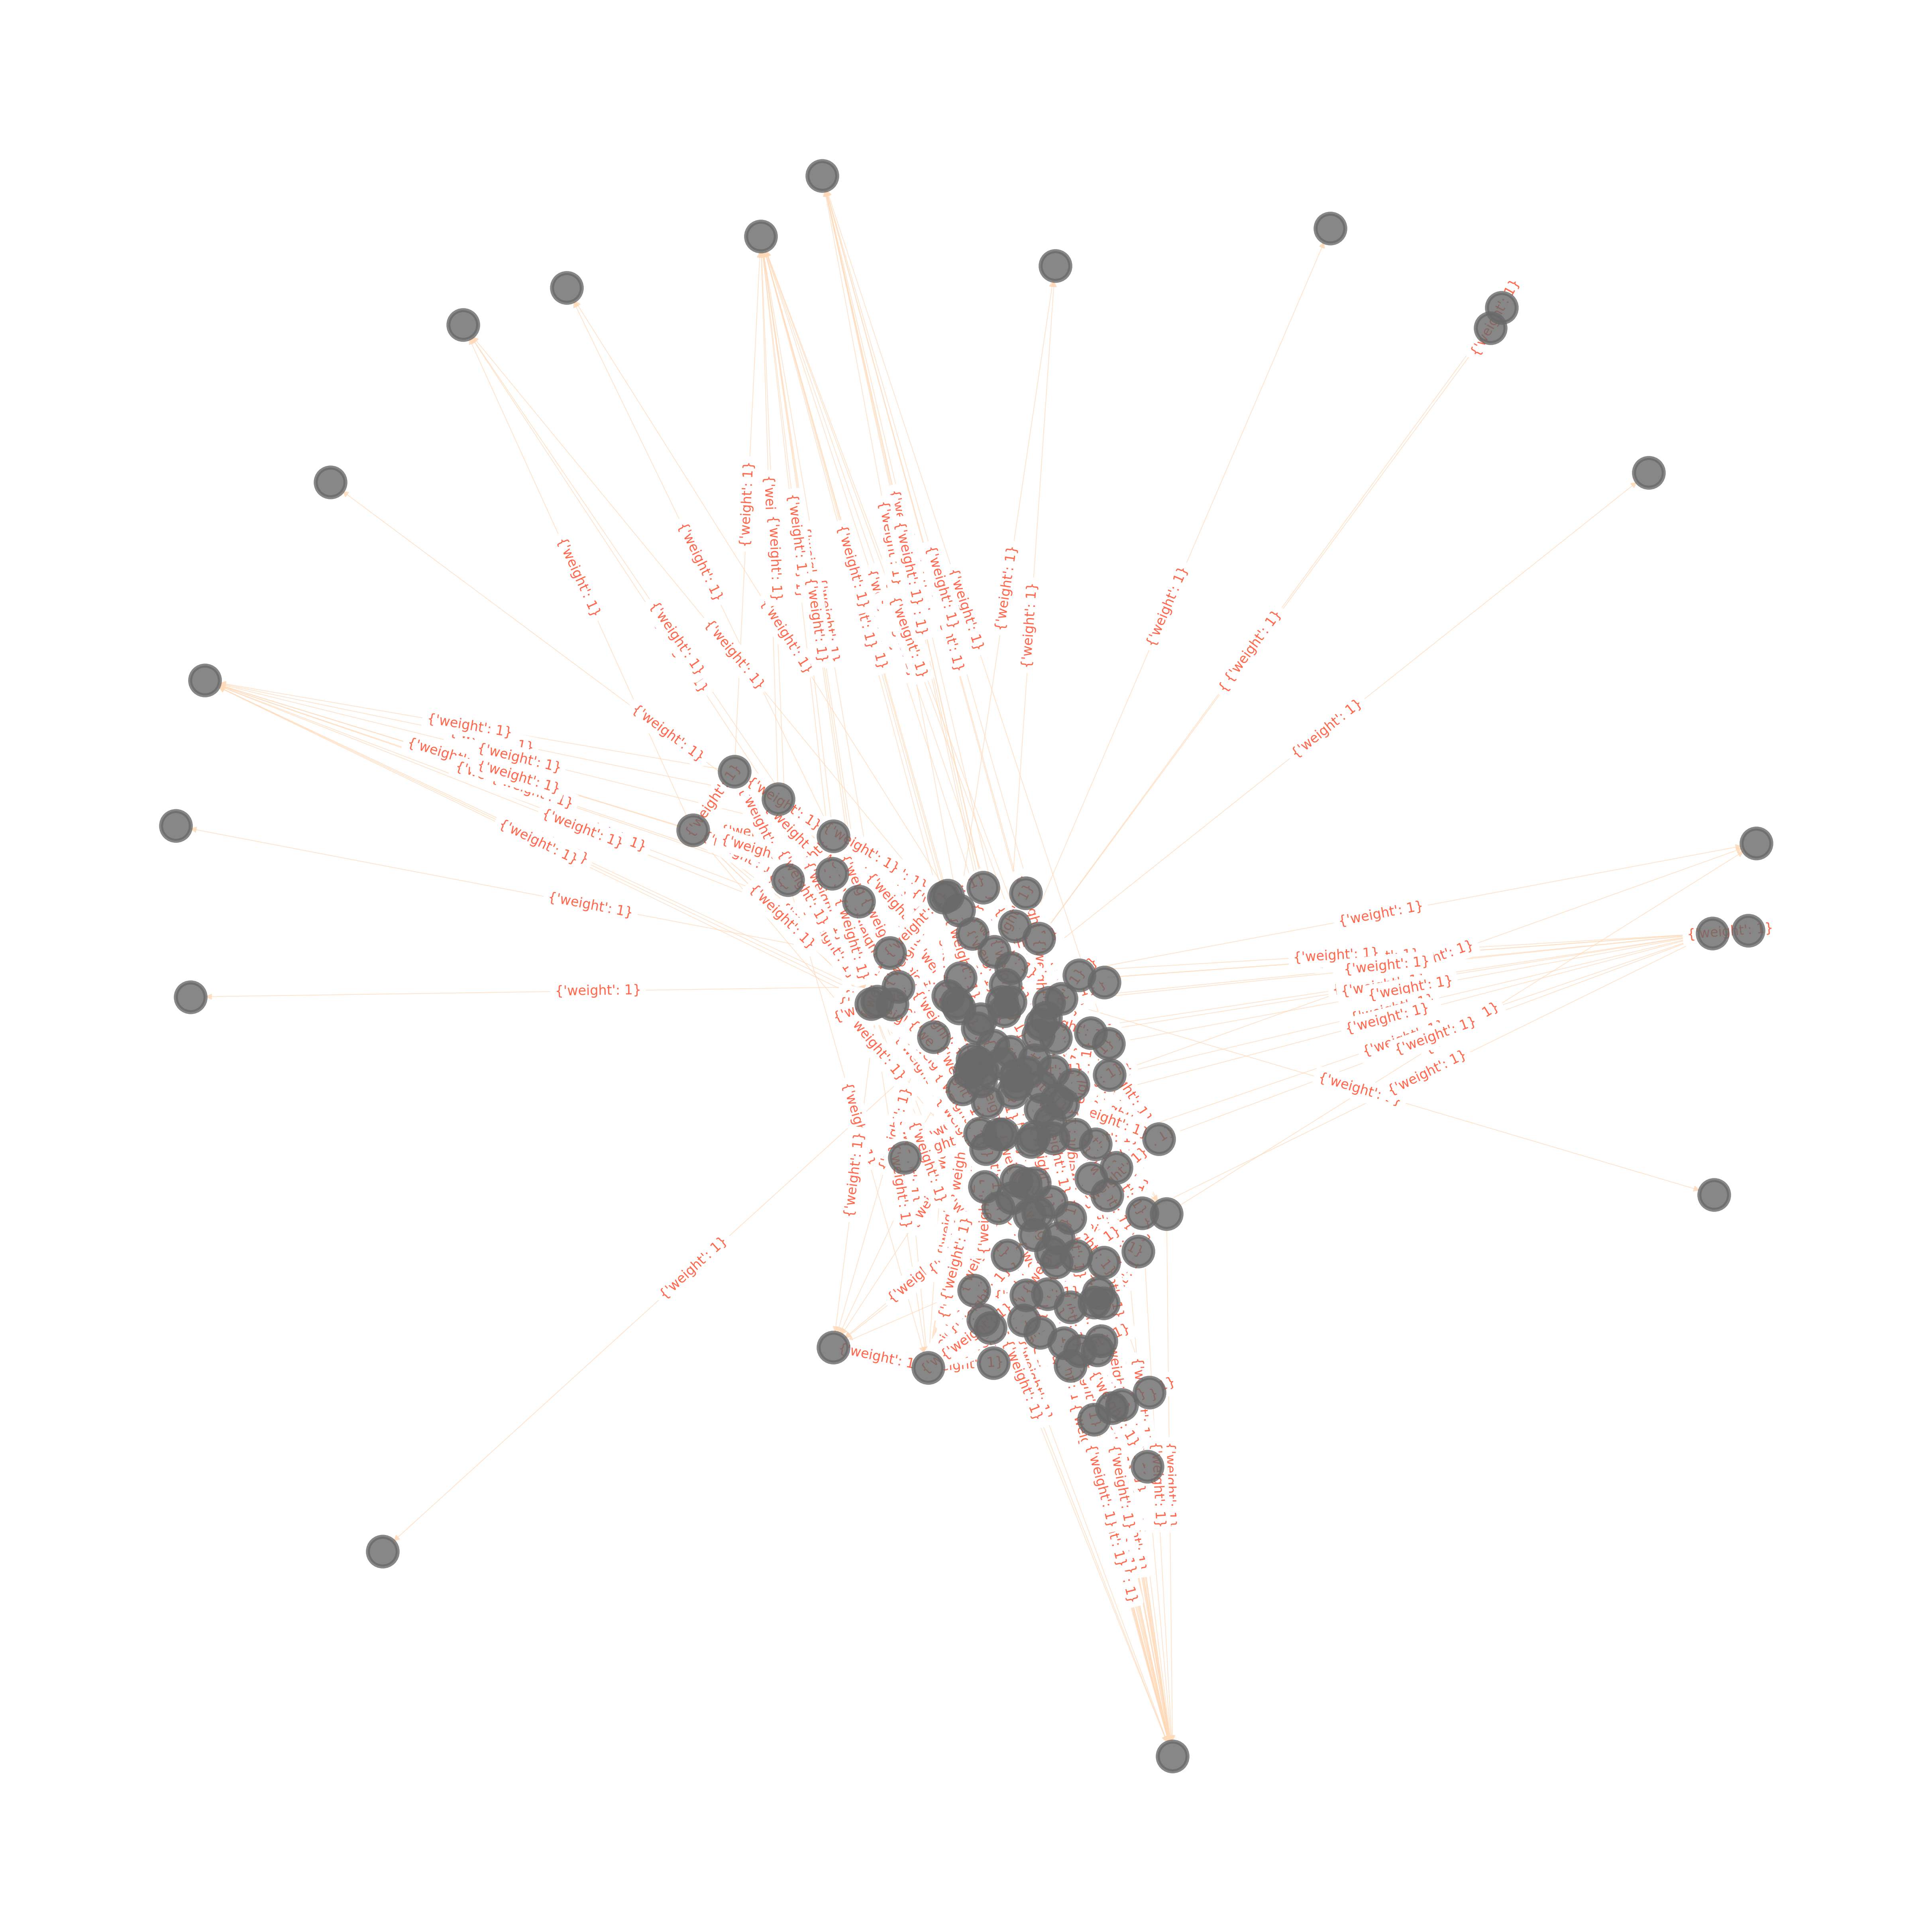

time: 22.9 s (started: 2022-04-18 14:44:17 -04:00)


In [7]:
G_s, _, _ = get_ego_graph(G, node=user)

node_labels_dict = dict(zip(nodes['id'], nodes['name']))
nx.set_node_attributes(G_s, node_labels_dict, "name")
node_labels = list(nx.get_node_attributes(G_s, "name").values())

print(f"{user}")
print(f"Nodes: {len(G_s.nodes())}, Edges: {len(G_s.edges())}")
print(f"Average Clustering: {round(nx.average_clustering(G_s), 3)}")
draw_nx_graph(G_s, fig_size  = (20, 20), font_size = 10, node_size = 500, linewidths = 3, width = 0.5, alpha = 0.8)

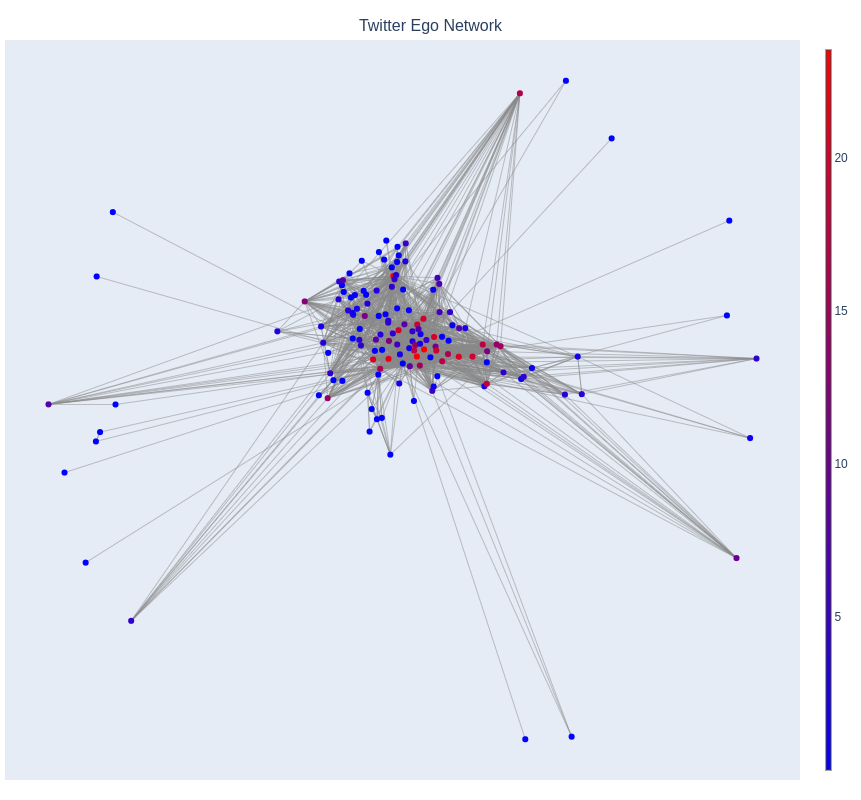

time: 1.83 s (started: 2022-04-18 14:44:40 -04:00)


In [8]:
draw_plotly_graph(G_s, node_labels=node_labels,node_colors='default', title='Twitter Ego Network')

## **Communities**


In [9]:
from community import community_louvain, generate_dendrogram, best_partition, induced_graph, modularity, partition_at_level
community_dict = community_louvain.best_partition(G_s.to_undirected(), random_state=42)
n_communities = pd.Series(community_dict.values()).nunique()
print(f"Communities at best partition: {n_communities}")
custom_colors = ['rgb(44,105,176)',
                 'rgb(240,39,32)',
                 'rgb(172,97,60)',
                 'rgb(107,163,214)',
                 'rgb(234,107,115)',
                 'rgb(65,68,81)'
                ]

custom_colors = np.resize(custom_colors, n_communities)

Communities at best partition: 5
time: 94.9 ms (started: 2022-04-18 14:44:42 -04:00)


In [10]:
nx.set_node_attributes(G_s, community_dict, "community")
node_community_map = list(nx.get_node_attributes(G_s, "community").values())
node_colors = [custom_colors[x] for x in node_community_map]

time: 52.6 ms (started: 2022-04-18 14:44:42 -04:00)


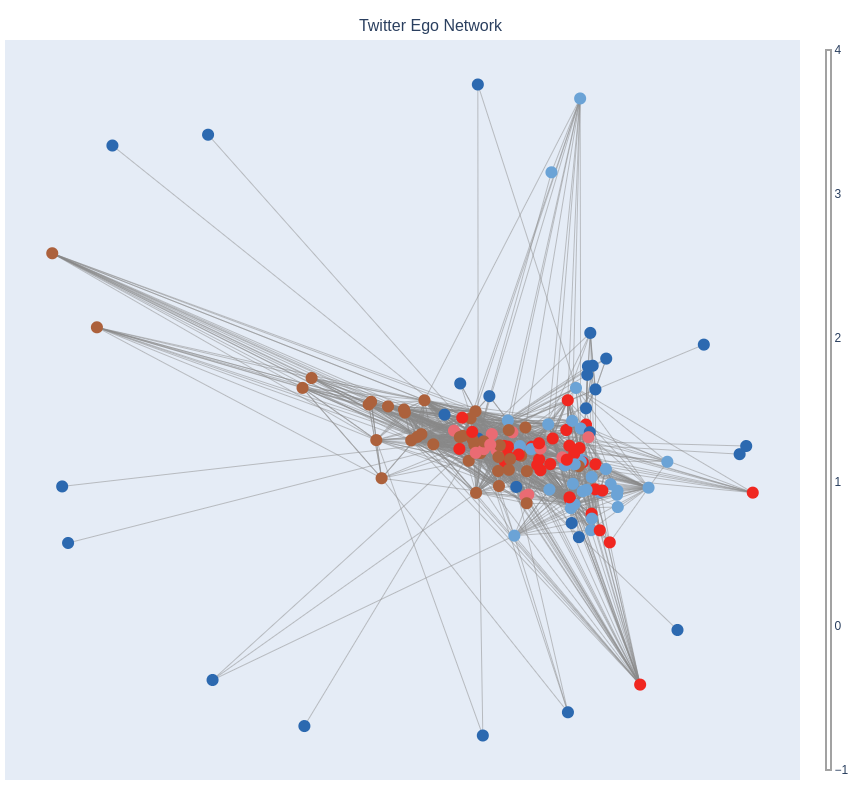

time: 271 ms (started: 2022-04-18 14:44:42 -04:00)


In [11]:
draw_plotly_graph(G_s, node_labels=node_labels, node_colors=node_colors, title='Twitter Ego Network', hide_color_axis=False, node_sizes = 12)

In [12]:
G_den = generate_dendrogram(G_s.to_undirected())
G_den = partition_at_level(G_den, len(G_den)-1)

G_part = best_partition(G_s.to_undirected(), random_state= 42)
G_s_c = induced_graph(G_part, G_s.to_undirected())
print(modularity(G_part, G_s.to_undirected()))

0.29393786859025706
time: 247 ms (started: 2022-04-18 14:44:43 -04:00)


In [16]:
# nodes_exp = nodes.copy()
# nodes_exp['community'] = nodes_exp['id'].apply(lambda x: G_part.get(x))
# TWITTER_NAME = nodes_exp[nodes_exp.username==TWITTER_USERNAME].name.unique()[0]
# nodes_exp['name'] = nodes_exp['name'].apply(lambda x: "<obf: name>" if x==TWITTER_NAME else str(x).lower())

# for n in range(n_communities):
#     print(f"\ncommunity {n}:")
#     comm_node_names = nodes_exp[nodes_exp.community==n].sort_values(by=['followers_count','tweet_count'], ascending=False).name.tolist()
#     print(*comm_node_names,sep='\n')

time: 878 µs (started: 2022-04-18 14:45:47 -04:00)


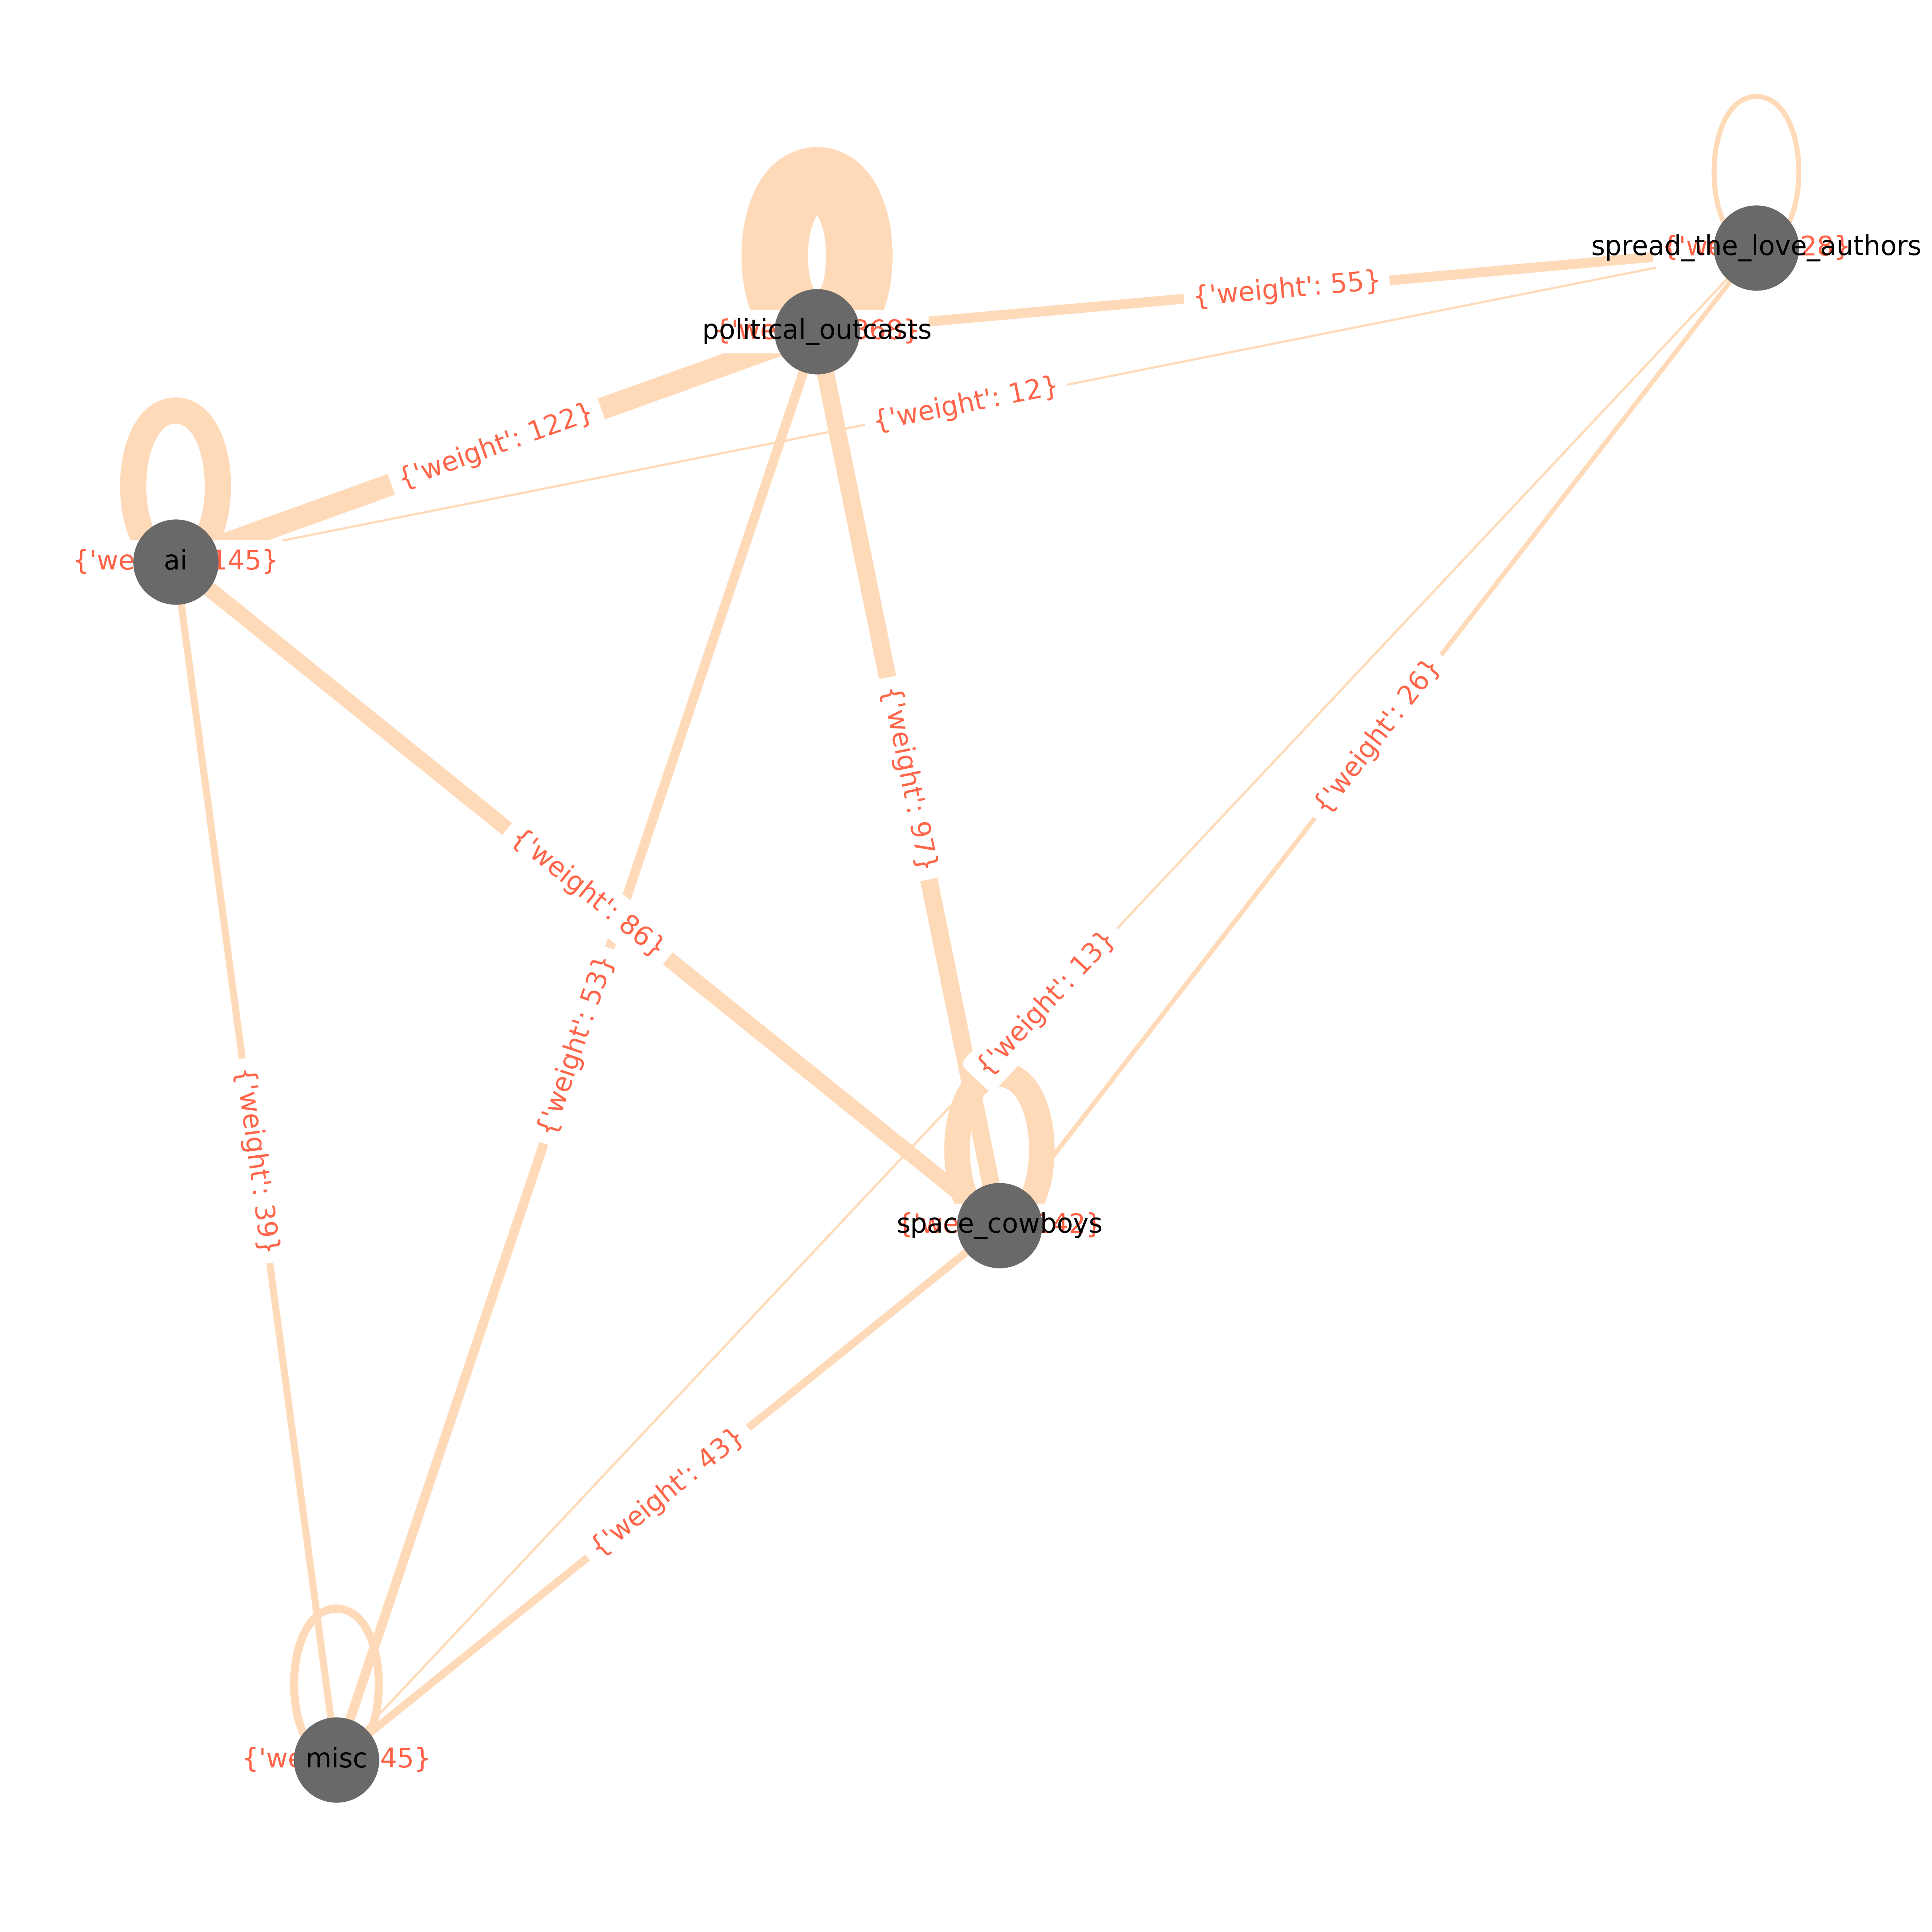

time: 2.19 s (started: 2022-04-18 14:44:43 -04:00)


In [14]:
edge_weights = list(nx.get_edge_attributes(G_s_c, "weight").values())
edge_weights = [50*x/max(edge_weights) for x in edge_weights]
comm_labels = {0: 'misc', 1: 'ai', 2: 'political_outcasts', 3: 'space_cowboys', 4: 'spread_the_love_authors'}

G_s_c_rl = nx.relabel_nodes(G_s_c, comm_labels, copy=True)
draw_nx_graph(G_s_c_rl, node_labels=True, width =  edge_weights, node_label_font_color = 'black', node_size = 4000, font_size = 20, alpha=1)

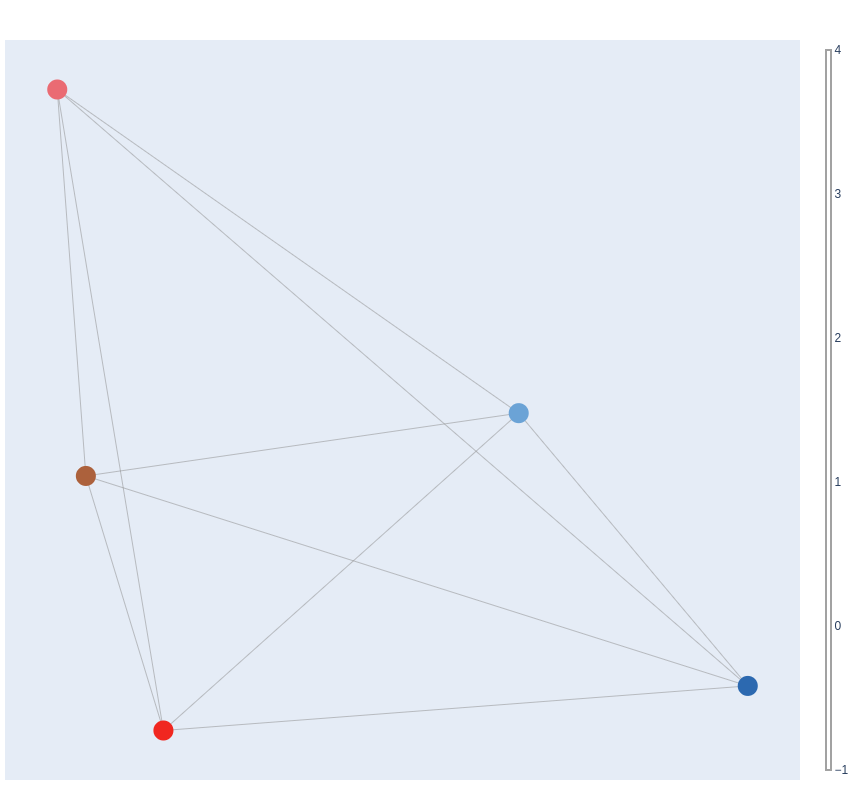

time: 18.6 ms (started: 2022-04-18 14:44:45 -04:00)


In [15]:
draw_plotly_graph(G_s_c, node_sizes = 20, node_colors = list(custom_colors))